In [1]:
from cluster import *
from load_data import *
from matplotlib import pyplot as plt
import sklearn, torch, random, numpy as np, pickle
from sklearn.model_selection import train_test_split
from classes import *

seed_num = 99
torch.manual_seed(seed_num)
np.random.seed(seed_num) #also sets sklearn seed
random.seed(seed_num)

In [2]:
file = '../Data/stations.dat'
if not isfile(file):
    save_stations(file)
station_id, coord, groups, points = cluster(file)
coord, points = np.array(coord), np.array(points)

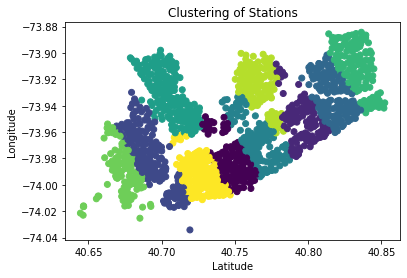

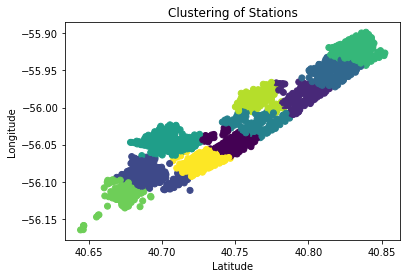

In [3]:
plt.scatter(coord[:, 0], coord[:, 1], c=groups)
plt.title('Clustering of Stations')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.savefig('../Graphs/Cluster.png', bbox_inches='tight')
plt.show()

plt.scatter(points[:, 0], points[:, 1], c=groups)
plt.title('Clustering of Stations')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.savefig('../Graphs/Cluster2.png', bbox_inches='tight')
plt.show()

In [4]:
file = '../Data/data.dat'
if isfile(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
else:
    try:
        data = load({station_id[i]: groups[i] for i in range(len(station_id))}, file)
    except FileNotFoundError:
        raise FileNotFoundError('Install the Citi Bike trip data for Jun 2013 to Jan 2021')

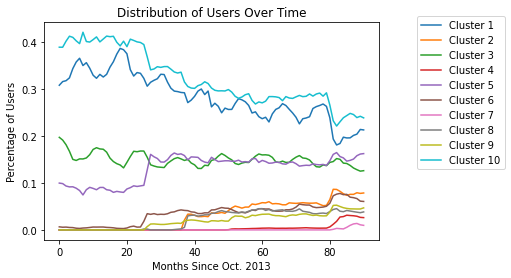

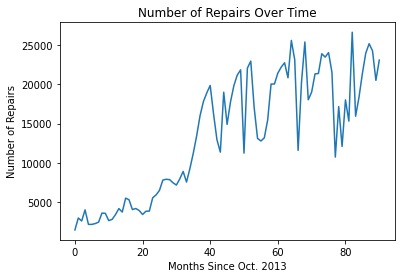

In [5]:
x, y, y2 = data
np_data = np.array(y2)

dates = []
for i in x:
    dates.append((i[0]-2013)*12+i[1]-6)
for i in range(10):
    plt.plot(dates, np_data[:, i], label="Cluster "+str(i+1))
plt.title("Distribution of Users Over Time")
plt.xlabel("Months Since Oct. 2013")
plt.ylabel("Percentage of Users")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig("../Graphs/Task 1.png", bbox_inches='tight')
plt.show()

np_data = np.array(y)
plt.plot(dates, np_data[:, 0])
plt.title("Number of Repairs Over Time")
plt.xlabel("Months Since Oct. 2013")
plt.ylabel("Number of Repairs")
plt.savefig("../Graphs/Task 2.png", bbox_inches='tight')
plt.show()

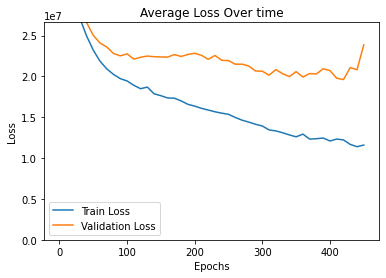

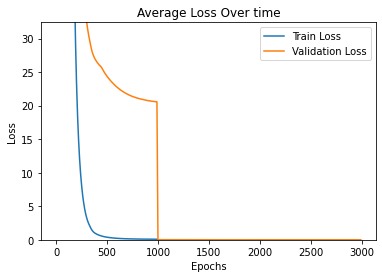

In [6]:
x, y, y2 = torch.tensor(x).float(), torch.tensor(y).float(), torch.tensor(y2).float()
x_train, x_test, y_train, y_test, y2_train, y2_test = train_test_split(x, y, y2, random_state=seed_num)

REPAIR_NN = [10]*35
DEMAND_NN = [10]*30

repair = NN.init(len(x_train[0]), len(y_train[0]), REPAIR_NN, '../Data/repair.pt', '../Graphs/Repair.png', x_train, y_train, 7500, 0)
demand = NN.init(len(x_train[0]), len(y2_train[0]), DEMAND_NN, '../Data/demand.pt', '../Graphs/Demand.png', x_train, y2_train, 3000, 0, demand=True)

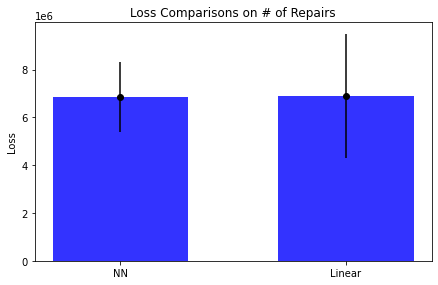

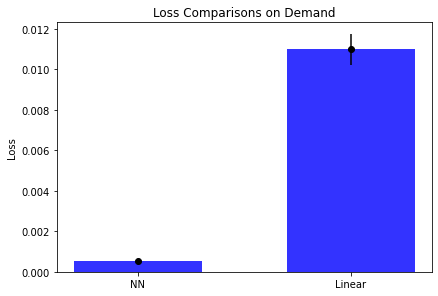

In [7]:
repair_linear = LinearRegression().fit(x_train, y_train)

demand_linear = MultiOutputLinear()
demand_linear.fit(x_train, y2_train)
loss_plot(repair, repair_linear, (x_test, y_test),
            '../Graphs/repair_loss.png', 'Loss Comparisons on # of Repairs', ('NN', 'Linear'))
loss_plot(demand, demand_linear, (x_test, y2_test),
            '../Graphs/demand_loss.png', 'Loss Comparisons on Demand', ('NN', 'Linear'))

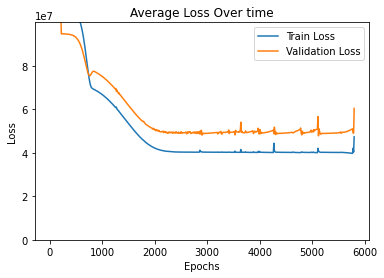

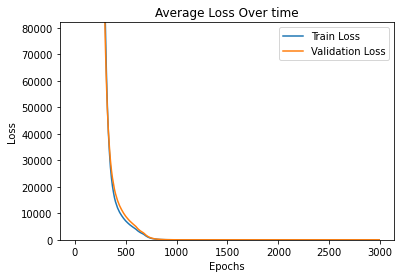

In [8]:
x_train2 = torch.tensor([i[:2] + [sum(i[2:12])] + i[12:] for i in x_train.tolist()])
x_test2 = torch.tensor([i[:2]+[sum(i[2:12])]+i[12:] for i in x_test.tolist()])

repair2 = NN.init(len(x_train2[0]), len(y_train[0]), REPAIR_NN, '../Data/repair2.pt', '../Graphs/Repair2.png', x_train2, y_train, 7500, 1000)

demand2 = NN.init(len(x_train2[0]), len(y2_train[0]), DEMAND_NN, '../Data/demand2.pt', '../Graphs/Demand2.png', x_train2, y2_train, 3000, 1000, demand=True)

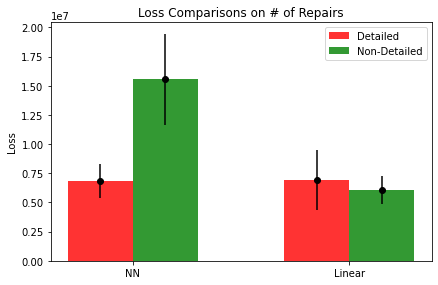

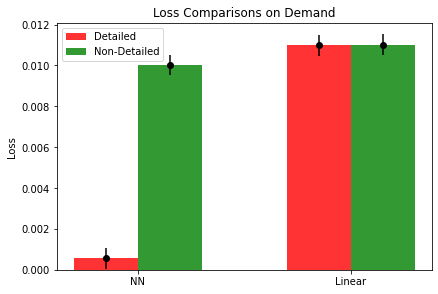

In [9]:
repair_linear2 = LinearRegression().fit(x_train2, y_train)
demand_linear2 = MultiOutputLinear()
demand_linear2.fit(x_train2, y2_train)

loss = nn.MSELoss()
index = np.arange(2)
losses = [(float(loss(repair(x_test), y_test)), float(loss(from_numpy(repair_linear.predict(x_test)), y_test))), 
        (float(loss(repair2(x_test2), y_test)), float(loss(from_numpy(repair_linear2.predict(x_test2)), y_test)))]
confidences = [(confidence(repair(x_test), y_test), confidence(from_numpy(repair_linear.predict(x_test)), y_test)),
                (confidence(repair2(x_test2), y_test), confidence(from_numpy(repair_linear2.predict(x_test2)), y_test))]
for i, c, l in [(0, 'r', 'Detailed'), (1, 'g', 'Non-Detailed')]:
    plt.bar(index+i*0.3, losses[i], 0.3, alpha=0.8, color=c, label=l)
    plt.errorbar(index+i*0.3, losses[i], yerr=confidences[i], fmt='o', color='black')

plt.xticks(index + 0.15, ("NN", "Linear"))
plt.legend()
plt.tight_layout()
plt.title("Loss Comparisons on # of Repairs")
plt.ylabel('Loss')
plt.savefig("../Graphs/Repair_detailed.png", bbox_inches='tight')
plt.show()

loss = nn.MSELoss()
index = np.arange(2)
losses = [(float(loss(demand(x_test), y2_test)), float(loss(demand_linear.predict(x_test), y2_test))), 
        (float(loss(demand2(x_test2), y2_test)), float(loss(demand_linear2.predict(x_test2), y2_test)))]
confidences = [(confidence(demand(x_test), y2_test), confidence(demand_linear.predict(x_test), y2_test)), 
                (confidence(demand2(x_test2), y2_test), confidence(demand_linear2.predict(x_test2), y2_test))]
for i, c, l in [(0, 'r', 'Detailed'), (1, 'g', 'Non-Detailed')]:
    plt.bar(index+i*0.3, losses[i], 0.3, alpha=0.8, color=c, label=l)
    plt.errorbar(index+i*0.3, losses[i], yerr=[0.0005]*2, fmt='o', color='black')
plt.xticks(index + 0.15, ("NN", "Linear"))
plt.legend()
plt.tight_layout()
plt.title("Loss Comparisons on Demand")
plt.ylabel('Loss')
plt.savefig("../Graphs/Demand_detailed.png", bbox_inches='tight')
plt.show()

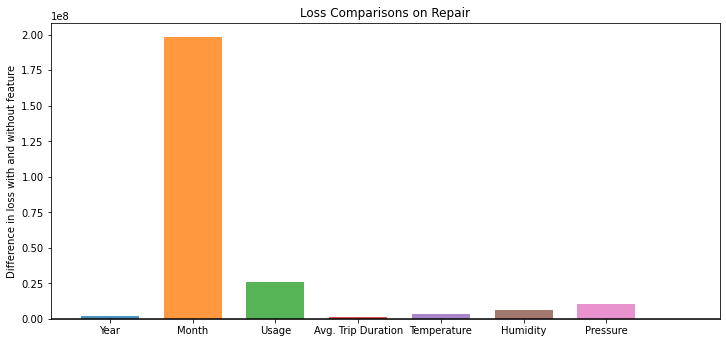

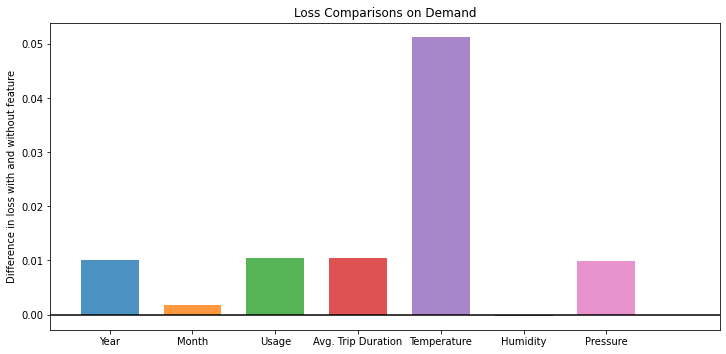

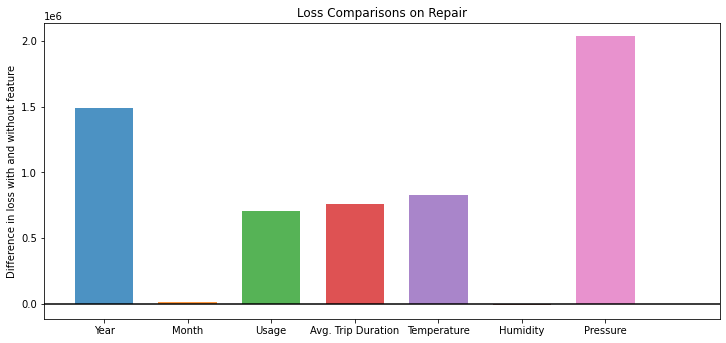

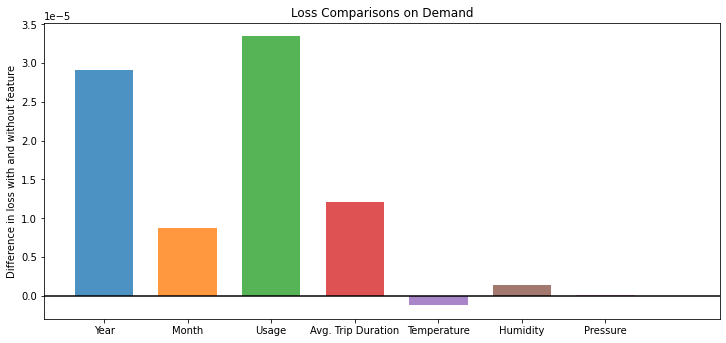

In [10]:
loss1 = []
loss2 = []
for n in list(range(3))+list(range(12, 16)):
    if n == 2:
        x_train2 = torch.tensor([i[:2]+i[12:] for i in x_train.tolist()])
        x_test2 = torch.tensor([i[:2]+i[12:] for i in x_test.tolist()])
    else:
        x_train2 = torch.tensor([i[:n] + i[n+1:] for i in x_train.tolist()])
        x_test2 = torch.tensor([i[:n] + i[n+1:] for i in x_test.tolist()])
    repair2 = NN.init(len(x_train2[0]), len(y_train[0]), REPAIR_NN, f'../Data/Feautures Removed/repair{n}.pt', None,
    x_train2, y_train, 7500, 1000)

    demand2 = NN.init(len(x_train2[0]), len(y2_train[0]), DEMAND_NN, f'../Data/Feautures Removed/demand{n}.pt', None, 
    x_train2, y2_train, 3000, 1000, demand=True)

    repair_linear2 = LinearRegression().fit(x_train2, y_train)
    demand_linear2 = MultiOutputLinear()
    demand_linear2.fit(x_train2, y2_train)

    loss1.append((float(loss(repair2(x_test2), y_test))-float(loss(repair(x_test), y_test)), 
                float(loss(from_numpy(repair_linear2.predict(x_test2)), y_test))-float(loss(from_numpy(repair_linear.predict(x_test)), y_test))))
    loss2.append((float(loss(demand2(x_test2), y2_test))-float(loss(demand(x_test), y2_test)), 
                float(loss(demand_linear2.predict(x_test2), y2_test))-float(loss(demand_linear.predict(x_test), y2_test))))
index = np.arange(1)
width = 1
plt.close()
# for li, n in [(loss1, "Repair"), (loss2, "Demand")]:
#     for i, l in enumerate(["Year", "Month", "Usage", "Avg. Trip Duration", "Temperature", "Humidity", "Pressure"]):
#         plt.bar(index+i*width, li[i], width, alpha=0.8, label=l)
#     plt.xticks(index + 3*width, ("NN", "Linear"))
#     plt.legend(loc='upper right')
#     plt.tight_layout()
#     plt.title("Loss Comparisons on "+n)
#     plt.ylabel('Loss Ratio Without feature to With it')
#     plt.axline((0, 1), (width*14+0.3, 1), c=(0, 0, 0))
#     plt.savefig(f"../Graphs/{n}_Feature_loss.png", bbox_inches='tight')
#     plt.show()
for num, name in enumerate(['NN', 'Linear']):
    for li, n in [(loss1, "Repair"), (loss2, "Demand")]:
        plt.figure(figsize=(10, 4.8)) 
        for i, l in enumerate(["Year", "Month", "Usage", "Avg. Trip Duration", "Temperature", "Humidity", "Pressure"]):
            plt.bar(index+i*width, li[i][num], width*0.7, alpha=0.8)
        plt.xticks(np.arange(7)*width, ["Year", "Month", "Usage", "Avg. Trip Duration", "Temperature", "Humidity", "Pressure"])
        plt.tight_layout()
        plt.title("Loss Comparisons on "+n)
        plt.ylabel('Difference in loss with and without feature')
        plt.axline((0, 0), (width*7, 0), c=(0, 0, 0))
        plt.savefig(f"../Graphs/{name}_{n}_Feature_loss.png", bbox_inches='tight')
        plt.show()

In [17]:
print(repair.loss_f(from_numpy(repair_linear.predict(x_train)), y_train), repair.loss_f(repair(x_train), y_train))
print(repair.loss_f(demand_linear.predict(x_train), y2_train), repair.loss_f(demand(x_train), y2_train))


tensor(7712377.5000) tensor(15261651., grad_fn=<MseLossBackward>)
